### Imports


In [1]:
import sys
sys.path.insert(0, '../utils')
sys.path.insert(0, '../Continuous-Weight-Balancing')

from weight_balancing import continuous_weight
from util import plot_cont_var, roc_sklearn_model, plot_loss

import numpy as np
import sklearn
import pandas as pd
from sklearn.metrics import roc_auc_score
from pathlib import *
from matplotlib import pyplot as plt
from scipy import stats
from math import pi
from pprint import pprint
## Sklearn models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


## Bokeh plotting
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.palettes import Spectral6
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot


Using TensorFlow backend.


In [2]:
#### Constants ####

SEED = 42
N_ESTIMATORS = 200 # Random Forest

In [3]:
output_notebook()

Loading BokehJS ...

## Understand the Heart Disease dataset 

In [4]:
df = pd.read_csv('../data/hd/data.csv')
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Let's have a look at what each of these columns means:

1. **age** -> Age of the person.
2. **sex** -> Sex of the person.  (1 = male; 0 = female)
3. **cp** -> Chest Pain Type. It can take values of 0, 1, 2, 3.
4. **trestbps** -> Resting Blood Presssure (Measured in mm Hg on admission to the hospital). It can take continuous values from 94 to 200.  
5. **chol** -> Serum Cholestrol in mg/dl. It also takes continuous values.
6. **fbs** -> Fasting Blood Sugar. It can take value of either 1 or 0.
7. **restecg** -> Resting Electrocardiographic Results. It can take value of 0, 1 or 2.
8. **thalach** -> Maximum Heart Rate achieved. It can take continuous value from 71 to 202.
9. **exang** -> Exercise Induced Angina. It can take value either of 0 or 1.
10. **oldpeak** -> ST depression induced by exercise relative to rest. It takes continuous decimal values.
11. **slope** -> the slope of the peak exercise ST segment. It can take value of either 0, 1 or 2.
12. **ca** -> Number of major vessels colored by flourosopy. It can take value of either 0, 1, 2, 3 or 4. 
13. **thal** -> 3 = normal; 6 = fixed defect; 7 = reversable defect
14. **target** -> Indicates the presence or absence of heart disease. (= the predicted attribute)

In [5]:
# unique, counts = np.unique(df['target'].values)
unique = ["0", '1']

top = [df['target'].value_counts()[0], df['target'].value_counts()[1]]
source = ColumnDataSource(data = dict(Target = unique, counts = top, color = Spectral6))

p = figure(
    x_range = unique,
    plot_height = 500,
    plot_width = 500,
    x_axis_label = 'Target',
    y_axis_label = 'Count(Target)',
    title = 'Count of People Having Heart Disease and Not Having Heart Disease',
    tools = "hover", tooltips="@Target: @counts"
)

p.vbar(
    x = 'Target',
    top = 'counts',
    bottom = 0,
    width = 0.9,
    source = source,
    color = 'color'
)

GlyphRenderer(id='1029', ...)

In [6]:
print("Percentage of people having Heart Disease", round(df['target'].value_counts()[1] / (df['target'].value_counts()[0] + df['target'].value_counts()[1]), 2) * 100)
print("Percentage of people not having Heart Disease", round(df['target'].value_counts()[0] / (df['target'].value_counts()[0] + df['target'].value_counts()[1]), 2) * 100)

Percentage of people having Heart Disease 54.0
Percentage of people not having Heart Disease 46.0


In [7]:
target = {
            'No Heart Disease' : df['target'].value_counts()[0], 
          'Have Heart Disease' : df['target'].value_counts()[1]
         }

data = pd.Series(target).reset_index(name = 'value').rename(columns = {'index':'target'})
data['angle'] = data['value']/data['value'].sum() * 2 * pi
data['color'] = ['skyblue', 'salmon']

In [8]:
p1 = figure(
            plot_height = 500, 
            plot_width = 500, 
            title = "Proportion of People Having Heart Disease and not Having Heart Disease", 
            toolbar_location = None,
            tools = "hover", 
            tooltips = "@target: @value", 
            x_range = (-0.5, 1.0)
            )

p1.wedge(
        x = 0, y = 1, radius = 0.4,
        start_angle = cumsum('angle', include_zero=True), 
        end_angle = cumsum('angle'),
        line_color = "white", 
        fill_color = 'color', 
        legend_field = 'target', 
        source = data
        )

p1.legend.location = "top_right"


p1.legend.label_text_font_size = '5pt'

show(gridplot([[p], [p1]]))

In [9]:
## Categorical vs Cont

categorical_var = []
continuous_var = []

for column in df.columns:
    if len(df[column].unique()) <= 10:
        categorical_var.append(column)
    else:
        continuous_var.append(column)
        
print("Categorical Variables are: ", categorical_var)
print("Continuous Variables are: ", continuous_var)

Categorical Variables are:  ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
Continuous Variables are:  ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


## Use-case



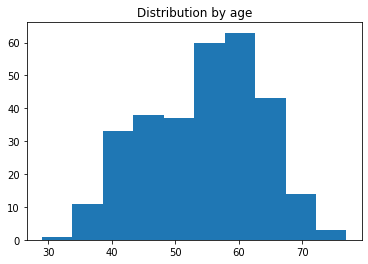

In [10]:
plt.hist(df['age'])
plt.title('Distribution by age')
plt.show()

In [11]:
p16 = plot_cont_var('age', df)
show(p16)

We see from the plot below that the dataset is biased heavily in favor of people aged 50 and above. However, looking at the label distributions, we find peaks in the histogram (for +ve labels) below age 50. This is a bias we would ideally like to eliminate through weight balancing.

### Loading dataset + weight traits

We assume all data is mean-normalized beforehand. The weights for age as a trait have been saved beforehand. 

In [12]:
data_dir = Path('../data/hd')
X_train = np.load(data_dir / 'X_train.npy')
y_train = np.load(data_dir / 'y_train.npy')
X_val = np.load(data_dir / 'X_val.npy')
y_val = np.load(data_dir / 'y_val.npy')
X_test = np.load(data_dir / 'X_test.npy')
y_test = np.load(data_dir / 'y_test.npy')


traits_train = np.load(data_dir / 'traits_train.npy')
traits_val = np.load(data_dir / 'traits_val.npy')
traits_test = np.load(data_dir / 'traits_test.npy')


# Merge both val & test sets for more samples
traits_oos = np.concatenate([traits_val, traits_test], 0)
X_oos = np.concatenate([X_val, X_test], 0)
y_oos = np.concatenate([y_val, y_test], 0)

# Below 60 years of age
CUTOFF = 60
X_below = X_oos[traits_oos < CUTOFF]
y_below = y_oos[traits_oos < CUTOFF]



In [13]:
traits_train.min(), traits_val.min(), traits_test.min(), traits_train.max(), traits_val.max(), traits_test.max()

(29, 35, 34, 77, 70, 71)

### Generating weights on the fly

In [14]:
## Load a scipy.stats.rv_continuous obj
min_trait = traits_train.min()
range_trait = traits_train.max() - traits_train.min()
target = stats.uniform(loc = min_trait, scale = range_trait)

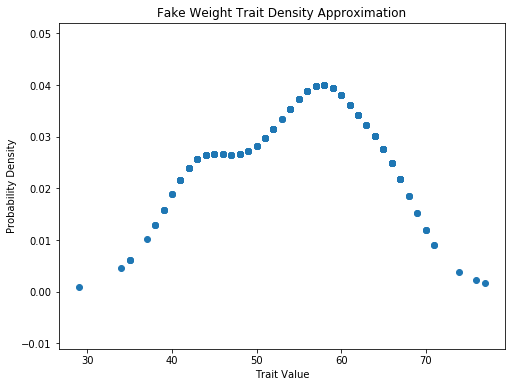

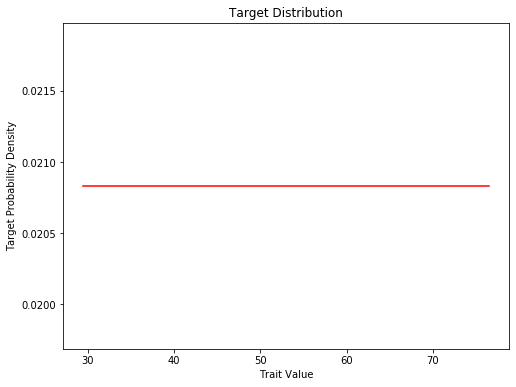

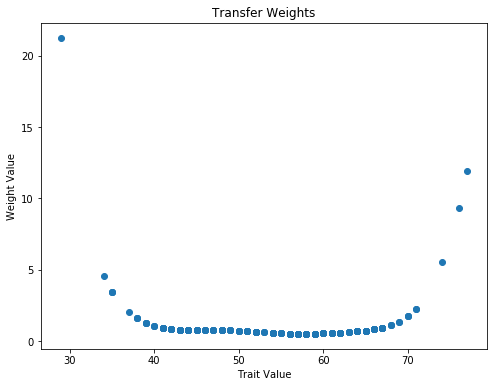

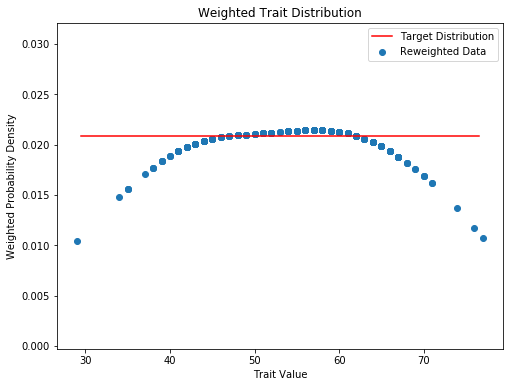

In [15]:
wts_tr = continuous_weight(traits_train, target, addl_trait = None, clipping = None, verbose = True)


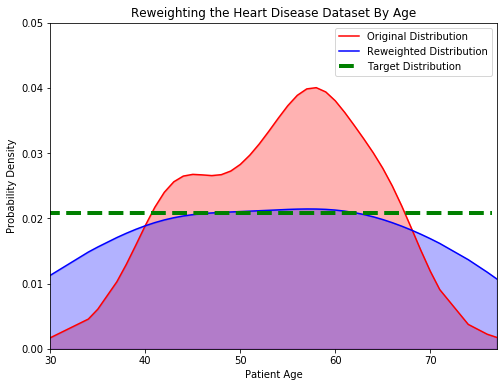

In [21]:
def comparison_graph(trait, target, weights):
    #Sort the trait and weights
    tmp = sorted(zip(trait,weights))
    trait = [item[0] for item in tmp]
    weights = [item[1] for item in tmp]
    
    source_kde = stats.gaussian_kde(trait)
    estimate = source_kde.evaluate(trait)
    
    plt.figure(figsize=(8, 6))
    plt.title("Reweighting the Heart Disease Dataset By Age")
    plt.xlabel("Patient Age")
    plt.ylabel("Probability Density")
    #Plot original
    plt.plot(trait, estimate, "r", label = "Original Distribution")
    plt.fill_between(trait, estimate, np.zeros(len(trait)), color = "r", alpha=0.3)
    
    #Plot weighted source
    weighted_kde = stats.gaussian_kde(trait, weights = weights)
    weighted_estimate = weighted_kde.evaluate(trait)
    plt.plot(trait, weighted_estimate, "b", label="Reweighted Distribution")
    plt.fill_between(trait, weighted_estimate, np.zeros(len(trait)), color = "b", alpha=0.3)

    #Plot target
    x = np.linspace(target.ppf(0.01),
                target.ppf(0.99), 100)
    plt.plot(x, target.pdf(x), "g--", label = "Target Distribution", linewidth = 4)
    
    plt.legend()
    plt.xlim([30, 77])
    plt.ylim([0, 0.05])
    plt.show()
    
comparison_graph(traits_train, target, wts_tr)

We notice weight trait (age in this example) isn't made exactly uniform, but we even out the peaks in the 40-60 age group.

# Part-1: Does CWB improve performance over uniform sampling? 

## Random Forest

#### Without sample balancing on the entire out-of-sample set


In [31]:
clf_unbalanced = RandomForestClassifier(n_estimators=100, random_state=SEED).fit(X_train, y_train, sample_weight=None)
roc_unbal = roc_sklearn_model(clf_unbalanced, X_oos, y_oos)
print("ROC value on unbalanced data: ", roc_unbal)

ROC value on unbalanced data:  0.9401939655172413


#### Now training using continuous sample-weights as a function of age

In [32]:
clf_balanced = RandomForestClassifier(n_estimators=100, random_state=SEED).fit(X_train, y_train, sample_weight=wts_tr)
roc_bal = roc_sklearn_model(clf_balanced, X_oos, y_oos)
print("ROC value on balanced data: ", roc_bal)

ROC value on balanced data:  0.9401939655172414


### Evaluating on ages below 60

In [33]:
## X_below & y_below defined at start of notebook

rf_probs = clf_unbalanced.predict_proba(X_below)[:, 1]
roc_value = roc_auc_score(y_below, rf_probs)
print("Unbalanced ROC_value: ", roc_value)

rf_probs_bal = clf_balanced.predict_proba(X_below)[:, 1]
roc_value_bal = roc_auc_score(y_below, rf_probs_bal)
print("Balanced ROC_value: ", roc_value_bal)


Unbalanced ROC_value:  0.9554924242424242
Balanced ROC_value:  0.9602272727272727


**Note**: Both models perform aboutthe same on the OOS set, but the model trained on balanced data outperforms on a dataset limiited to subjects < 60

## Logistic Regression

#### Without sample balancing on the entire out-of-sample set


In [34]:
clf_unbalanced = LogisticRegression(random_state=SEED).fit(X_train, y_train, sample_weight=None)
roc_value_unbal = roc_sklearn_model(clf_unbalanced, X_oos, y_oos)

print("ROC value for unbalanced data: ", roc_value_unbal) 

ROC value for unbalanced data:  0.9245689655172413


#### Now training using continuous sample-weights as a function of age

In [35]:
clf_balanced = LogisticRegression(random_state=SEED).fit(X_train, y_train, sample_weight=wts_tr)
roc_value_bal = roc_sklearn_model(clf_balanced, X_oos, y_oos)

print("ROC value for unbalanced data: ", roc_value_bal) 

ROC value for unbalanced data:  0.9267241379310345


### Evaluating on ages below 60


In [36]:
## X_below & y_below defined at start of notebook

rf_probs = clf_unbalanced.predict_proba(X_below)[:, 1]
roc_value = roc_auc_score(y_below, rf_probs)
print("Unbalanced ROC_value: ", roc_value)

rf_probs_bal = clf_balanced.predict_proba(X_below)[:, 1]
roc_value_bal = roc_auc_score(y_below, rf_probs_bal)
print("Balanced ROC_value: ", roc_value_bal)


Unbalanced ROC_value:  0.9261363636363638
Balanced ROC_value:  0.9242424242424243


The balanced model does slightly worse, but the difference is *within* 0.2 %.

## Deep Neural Net

In [24]:
from tqdm import tqdm
def make_nn():
    model = Sequential()
    model.add(Dense(64, input_dim=13, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(16, activation='relu'))
#     model.add(Dropout(.5))
#     model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

es = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=25, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, 
                       mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
callbacks = [es, lr]

args_dict = {'x': X_train,
             'y': y_train,
             'epochs': 100,
             'validation_data': (X_val, y_val),
             'verbose': 1,
             'batch_size': 16,
             'callbacks': callbacks
            }

class Ensemble: 
    def __init__(self, size=10):
        self.models = [make_nn() for _ in range(size)]
        
    def print_summary(self):
        self.models[0].summary()
    def fit(self, args_dict, sample_weight=None):
        for model in tqdm(self.models):
            model.fit(**args_dict, sample_weight=sample_weight)
    def validate_roc(self, X, y):
        return roc_auc_score(y, np.mean(np.concatenate([model.predict(X) for model in self.models], 1), 1))

    

**Note**: Due to the variance in Neural Net performance as a result of the random seed, we train an _ensemble_ of 10 models for each data-balancing scheme and average out the predictions on the out-of-sample test

#### First training with unbalanced data

In [26]:
nn_unbalanced = Ensemble(10)
nn_unbalanced.print_summary()

nn_unbalanced.fit(args_dict)
roc_value = nn_unbalanced.validate_roc(X_oos, y_oos)
print("Unbalanced ROC_value: ", roc_value)

  0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 64)                896       
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 17        
Total params: 1,953
Trainable params: 1,953
Non-trainable params: 0
_________________________________________________________________
Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6859 - accuracy: 0.5207 - val_loss: 0.6086 - val_accuracy: 0.7667
Epoch 2/100
242/242 [==============================] - 0s 161

 10%|█         | 1/10 [00:06<00:58,  6.49s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7785 - accuracy: 0.5661 - val_loss: 0.7257 - val_accuracy: 0.5667
Epoch 2/100
242/242 [==============================] - 0s 143us/step - loss: 0.6822 - accuracy: 0.5909 - val_loss: 0.6542 - val_accuracy: 0.5667
Epoch 3/100
242/242 [==============================] - 0s 136us/step - loss: 0.6179 - accuracy: 0.6529 - val_loss: 0.5962 - val_accuracy: 0.6000
Epoch 4/100
242/242 [==============================] - 0s 133us/step - loss: 0.5720 - accuracy: 0.7231 - val_loss: 0.5527 - val_accuracy: 0.6667
Epoch 5/100
242/242 [==============================] - 0s 129us/step - loss: 0.5598 - accuracy: 0.7521 - val_loss: 0.5162 - val_accuracy: 0.7667
Epoch 6/100
242/242 [==============================] - 0s 127us/step - loss: 0.5101 - accuracy: 0.7851 - val_loss: 0.4763 - val_accuracy: 0.8333
Epoch 7/100
242/242 [==============================] - 0s 131us/step - loss: 0.4859 - a

 20%|██        | 2/10 [00:12<00:50,  6.31s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7422 - accuracy: 0.4959 - val_loss: 0.6535 - val_accuracy: 0.5667
Epoch 2/100
242/242 [==============================] - 0s 144us/step - loss: 0.6535 - accuracy: 0.6116 - val_loss: 0.5860 - val_accuracy: 0.7000
Epoch 3/100
242/242 [==============================] - 0s 134us/step - loss: 0.5890 - accuracy: 0.6653 - val_loss: 0.5373 - val_accuracy: 0.7667
Epoch 4/100
242/242 [==============================] - 0s 134us/step - loss: 0.5459 - accuracy: 0.7851 - val_loss: 0.4946 - val_accuracy: 0.8000
Epoch 5/100
242/242 [==============================] - 0s 129us/step - loss: 0.5170 - accuracy: 0.7851 - val_loss: 0.4592 - val_accuracy: 0.8333
Epoch 6/100
242/242 [==============================] - 0s 123us/step - loss: 0.4742 - accuracy: 0.8058 - val_loss: 0.4278 - val_accuracy: 0.8333
Epoch 7/100
242/242 [==============================] - 0s 126us/step - loss: 0.4829 - a

 30%|███       | 3/10 [00:19<00:47,  6.76s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.6839 - accuracy: 0.5785 - val_loss: 0.6225 - val_accuracy: 0.6667
Epoch 2/100
242/242 [==============================] - 0s 147us/step - loss: 0.6296 - accuracy: 0.6653 - val_loss: 0.5855 - val_accuracy: 0.6333
Epoch 3/100
242/242 [==============================] - 0s 139us/step - loss: 0.5461 - accuracy: 0.7355 - val_loss: 0.5592 - val_accuracy: 0.6667
Epoch 4/100
242/242 [==============================] - 0s 136us/step - loss: 0.5276 - accuracy: 0.7769 - val_loss: 0.5357 - val_accuracy: 0.6667
Epoch 5/100
242/242 [==============================] - 0s 131us/step - loss: 0.4954 - accuracy: 0.8182 - val_loss: 0.5088 - val_accuracy: 0.6667
Epoch 6/100
242/242 [==============================] - 0s 136us/step - loss: 0.4965 - accuracy: 0.7438 - val_loss: 0.4901 - val_accuracy: 0.7000
Epoch 7/100
242/242 [==============================] - 0s 135us/step - loss: 0.4761 - a

 40%|████      | 4/10 [00:27<00:41,  6.99s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7075 - accuracy: 0.5620 - val_loss: 0.6729 - val_accuracy: 0.5667
Epoch 2/100
242/242 [==============================] - 0s 186us/step - loss: 0.6292 - accuracy: 0.6240 - val_loss: 0.5912 - val_accuracy: 0.6333
Epoch 3/100
242/242 [==============================] - 0s 167us/step - loss: 0.5792 - accuracy: 0.7066 - val_loss: 0.5447 - val_accuracy: 0.7667
Epoch 4/100
242/242 [==============================] - 0s 154us/step - loss: 0.5207 - accuracy: 0.7562 - val_loss: 0.4999 - val_accuracy: 0.7667
Epoch 5/100
242/242 [==============================] - 0s 135us/step - loss: 0.5205 - accuracy: 0.7727 - val_loss: 0.4696 - val_accuracy: 0.8000
Epoch 6/100
242/242 [==============================] - 0s 139us/step - loss: 0.4838 - accuracy: 0.7934 - val_loss: 0.4411 - val_accuracy: 0.7667
Epoch 7/100
242/242 [==============================] - 0s 147us/step - loss: 0.4522 - a

 50%|█████     | 5/10 [00:35<00:36,  7.37s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7513 - accuracy: 0.5579 - val_loss: 0.6533 - val_accuracy: 0.6000
Epoch 2/100
242/242 [==============================] - 0s 143us/step - loss: 0.6690 - accuracy: 0.6033 - val_loss: 0.5973 - val_accuracy: 0.7333
Epoch 3/100
242/242 [==============================] - 0s 167us/step - loss: 0.5893 - accuracy: 0.6942 - val_loss: 0.5553 - val_accuracy: 0.7333
Epoch 4/100
242/242 [==============================] - 0s 156us/step - loss: 0.5693 - accuracy: 0.7066 - val_loss: 0.5185 - val_accuracy: 0.8000
Epoch 5/100
242/242 [==============================] - 0s 155us/step - loss: 0.5366 - accuracy: 0.7727 - val_loss: 0.4903 - val_accuracy: 0.8333
Epoch 6/100
242/242 [==============================] - 0s 125us/step - loss: 0.5110 - accuracy: 0.7686 - val_loss: 0.4673 - val_accuracy: 0.8333
Epoch 7/100
242/242 [==============================] - 0s 155us/step - loss: 0.4894 - a

 60%|██████    | 6/10 [00:42<00:29,  7.43s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7537 - accuracy: 0.5496 - val_loss: 0.6596 - val_accuracy: 0.5333
Epoch 2/100
242/242 [==============================] - 0s 128us/step - loss: 0.6517 - accuracy: 0.5826 - val_loss: 0.6121 - val_accuracy: 0.6667
Epoch 3/100
242/242 [==============================] - 0s 111us/step - loss: 0.5994 - accuracy: 0.6860 - val_loss: 0.5733 - val_accuracy: 0.6667
Epoch 4/100
242/242 [==============================] - 0s 110us/step - loss: 0.5745 - accuracy: 0.7107 - val_loss: 0.5395 - val_accuracy: 0.7667
Epoch 5/100
242/242 [==============================] - 0s 104us/step - loss: 0.5421 - accuracy: 0.7686 - val_loss: 0.5107 - val_accuracy: 0.8667
Epoch 6/100
242/242 [==============================] - 0s 104us/step - loss: 0.4981 - accuracy: 0.8017 - val_loss: 0.4834 - val_accuracy: 0.8333
Epoch 7/100
242/242 [==============================] - 0s 118us/step - loss: 0.4819 - a

 70%|███████   | 7/10 [00:49<00:21,  7.11s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7029 - accuracy: 0.5620 - val_loss: 0.5990 - val_accuracy: 0.6333
Epoch 2/100
242/242 [==============================] - 0s 138us/step - loss: 0.6173 - accuracy: 0.6901 - val_loss: 0.5319 - val_accuracy: 0.7333
Epoch 3/100
242/242 [==============================] - 0s 151us/step - loss: 0.5662 - accuracy: 0.7479 - val_loss: 0.4840 - val_accuracy: 0.7333
Epoch 4/100
242/242 [==============================] - 0s 149us/step - loss: 0.5173 - accuracy: 0.7727 - val_loss: 0.4468 - val_accuracy: 0.7667
Epoch 5/100
242/242 [==============================] - 0s 136us/step - loss: 0.4913 - accuracy: 0.7603 - val_loss: 0.4153 - val_accuracy: 0.7667
Epoch 6/100
242/242 [==============================] - 0s 131us/step - loss: 0.4462 - accuracy: 0.8306 - val_loss: 0.3955 - val_accuracy: 0.7667
Epoch 7/100
242/242 [==============================] - 0s 126us/step - loss: 0.4501 - a

 80%|████████  | 8/10 [00:56<00:14,  7.12s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7872 - accuracy: 0.4711 - val_loss: 0.5557 - val_accuracy: 0.8000
Epoch 2/100
242/242 [==============================] - 0s 128us/step - loss: 0.6656 - accuracy: 0.6074 - val_loss: 0.4972 - val_accuracy: 0.8667
Epoch 3/100
242/242 [==============================] - 0s 115us/step - loss: 0.6031 - accuracy: 0.6612 - val_loss: 0.4579 - val_accuracy: 0.9333
Epoch 4/100
242/242 [==============================] - 0s 109us/step - loss: 0.5933 - accuracy: 0.6694 - val_loss: 0.4275 - val_accuracy: 0.9000
Epoch 5/100
242/242 [==============================] - 0s 106us/step - loss: 0.5279 - accuracy: 0.7397 - val_loss: 0.3995 - val_accuracy: 0.8667
Epoch 6/100
242/242 [==============================] - 0s 106us/step - loss: 0.5046 - accuracy: 0.7851 - val_loss: 0.3753 - val_accuracy: 0.8667
Epoch 7/100
242/242 [==============================] - 0s 126us/step - loss: 0.4571 - a

 90%|█████████ | 9/10 [01:03<00:06,  6.96s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7106 - accuracy: 0.4917 - val_loss: 0.6074 - val_accuracy: 0.7333
Epoch 2/100
242/242 [==============================] - 0s 160us/step - loss: 0.6544 - accuracy: 0.6446 - val_loss: 0.5650 - val_accuracy: 0.8333
Epoch 3/100
242/242 [==============================] - 0s 136us/step - loss: 0.6218 - accuracy: 0.6901 - val_loss: 0.5205 - val_accuracy: 0.8667
Epoch 4/100
242/242 [==============================] - 0s 125us/step - loss: 0.5427 - accuracy: 0.7645 - val_loss: 0.4870 - val_accuracy: 0.9000
Epoch 5/100
242/242 [==============================] - 0s 118us/step - loss: 0.5359 - accuracy: 0.7438 - val_loss: 0.4577 - val_accuracy: 0.9000
Epoch 6/100
242/242 [==============================] - 0s 116us/step - loss: 0.5140 - accuracy: 0.7603 - val_loss: 0.4341 - val_accuracy: 0.8667
Epoch 7/100
242/242 [==============================] - 0s 115us/step - loss: 0.4681 - a

100%|██████████| 10/10 [01:10<00:00,  7.04s/it]


Unbalanced ROC_value:  0.9364224137931034


#### Now with a continuously-balanced dataset

In [27]:
nn_balanced = Ensemble(10)
nn_balanced.print_summary()

nn_balanced.fit(args_dict, wts_tr)
roc_value = nn_balanced.validate_roc(X_oos, y_oos)
print("Balanced ROC_value: ", roc_value)

  0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 64)                896       
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 17        
Total params: 1,953
Trainable params: 1,953
Non-trainable params: 0
_________________________________________________________________
Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.7052 - accuracy: 0.5496 - val_loss: 0.5869 - val_accuracy: 0.8000
Epoch 2/100
242/242 [==============================] - 0s 130

 10%|█         | 1/10 [00:07<01:08,  7.58s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6435 - accuracy: 0.5702 - val_loss: 0.6247 - val_accuracy: 0.6667
Epoch 2/100
242/242 [==============================] - 0s 181us/step - loss: 0.6308 - accuracy: 0.6405 - val_loss: 0.5730 - val_accuracy: 0.8000
Epoch 3/100
242/242 [==============================] - 0s 185us/step - loss: 0.5536 - accuracy: 0.6818 - val_loss: 0.5405 - val_accuracy: 0.7667
Epoch 4/100
242/242 [==============================] - 0s 174us/step - loss: 0.5359 - accuracy: 0.6942 - val_loss: 0.5120 - val_accuracy: 0.7667
Epoch 5/100
242/242 [==============================] - 0s 146us/step - loss: 0.4923 - accuracy: 0.7686 - val_loss: 0.4877 - val_accuracy: 0.8333
Epoch 6/100
242/242 [==============================] - 0s 131us/step - loss: 0.4366 - accuracy: 0.7810 - val_loss: 0.4662 - val_accuracy: 0.9000
Epoch 7/100
242/242 [==============================] - 0s 169us/step - loss: 0.4540 - a

 20%|██        | 2/10 [00:15<01:01,  7.65s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6585 - accuracy: 0.5702 - val_loss: 0.6087 - val_accuracy: 0.7667
Epoch 2/100
242/242 [==============================] - 0s 175us/step - loss: 0.5609 - accuracy: 0.6694 - val_loss: 0.5595 - val_accuracy: 0.7333
Epoch 3/100
242/242 [==============================] - 0s 160us/step - loss: 0.5153 - accuracy: 0.7521 - val_loss: 0.5203 - val_accuracy: 0.8000
Epoch 4/100
242/242 [==============================] - 0s 132us/step - loss: 0.4912 - accuracy: 0.7727 - val_loss: 0.4807 - val_accuracy: 0.8333
Epoch 5/100
242/242 [==============================] - 0s 130us/step - loss: 0.4866 - accuracy: 0.7521 - val_loss: 0.4486 - val_accuracy: 0.8333
Epoch 6/100
242/242 [==============================] - 0s 168us/step - loss: 0.4434 - accuracy: 0.7851 - val_loss: 0.4222 - val_accuracy: 0.8333
Epoch 7/100
242/242 [==============================] - 0s 166us/step - loss: 0.4110 - a

 30%|███       | 3/10 [00:23<00:54,  7.78s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 0.8100 - accuracy: 0.4876 - val_loss: 0.6620 - val_accuracy: 0.5333
Epoch 2/100
242/242 [==============================] - 0s 178us/step - loss: 0.6777 - accuracy: 0.6198 - val_loss: 0.6189 - val_accuracy: 0.7333
Epoch 3/100
242/242 [==============================] - 0s 153us/step - loss: 0.6257 - accuracy: 0.6240 - val_loss: 0.5910 - val_accuracy: 0.7333
Epoch 4/100
242/242 [==============================] - 0s 137us/step - loss: 0.5566 - accuracy: 0.6694 - val_loss: 0.5638 - val_accuracy: 0.7667
Epoch 5/100
242/242 [==============================] - 0s 125us/step - loss: 0.5348 - accuracy: 0.6570 - val_loss: 0.5392 - val_accuracy: 0.7000
Epoch 6/100
242/242 [==============================] - 0s 119us/step - loss: 0.5015 - accuracy: 0.7562 - val_loss: 0.5177 - val_accuracy: 0.7667
Epoch 7/100
242/242 [==============================] - 0s 124us/step - loss: 0.4711 - a

 40%|████      | 4/10 [00:32<00:49,  8.26s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6915 - accuracy: 0.5289 - val_loss: 0.6326 - val_accuracy: 0.6667
Epoch 2/100
242/242 [==============================] - 0s 131us/step - loss: 0.5832 - accuracy: 0.6488 - val_loss: 0.5772 - val_accuracy: 0.7333
Epoch 3/100
242/242 [==============================] - 0s 118us/step - loss: 0.5654 - accuracy: 0.6983 - val_loss: 0.5357 - val_accuracy: 0.8000
Epoch 4/100
242/242 [==============================] - 0s 114us/step - loss: 0.4987 - accuracy: 0.7231 - val_loss: 0.5018 - val_accuracy: 0.7667
Epoch 5/100
242/242 [==============================] - 0s 151us/step - loss: 0.4569 - accuracy: 0.7521 - val_loss: 0.4780 - val_accuracy: 0.7333
Epoch 6/100
242/242 [==============================] - 0s 169us/step - loss: 0.4492 - accuracy: 0.7562 - val_loss: 0.4578 - val_accuracy: 0.7667
Epoch 7/100
242/242 [==============================] - 0s 163us/step - loss: 0.3987 - a

 50%|█████     | 5/10 [00:41<00:43,  8.66s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6627 - accuracy: 0.5702 - val_loss: 0.6189 - val_accuracy: 0.7333
Epoch 2/100
242/242 [==============================] - 0s 171us/step - loss: 0.5609 - accuracy: 0.6818 - val_loss: 0.5643 - val_accuracy: 0.8333
Epoch 3/100
242/242 [==============================] - 0s 171us/step - loss: 0.5889 - accuracy: 0.6983 - val_loss: 0.5282 - val_accuracy: 0.8333
Epoch 4/100
242/242 [==============================] - 0s 184us/step - loss: 0.5013 - accuracy: 0.6901 - val_loss: 0.4994 - val_accuracy: 0.8667
Epoch 5/100
242/242 [==============================] - 0s 168us/step - loss: 0.4608 - accuracy: 0.7438 - val_loss: 0.4688 - val_accuracy: 0.8667
Epoch 6/100
242/242 [==============================] - 0s 149us/step - loss: 0.4747 - accuracy: 0.7769 - val_loss: 0.4486 - val_accuracy: 0.8667
Epoch 7/100
242/242 [==============================] - 0s 140us/step - loss: 0.4153 - a

 60%|██████    | 6/10 [00:50<00:35,  8.80s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7039 - accuracy: 0.5331 - val_loss: 0.6608 - val_accuracy: 0.6333
Epoch 2/100
242/242 [==============================] - 0s 172us/step - loss: 0.6430 - accuracy: 0.5744 - val_loss: 0.6177 - val_accuracy: 0.7333
Epoch 3/100
242/242 [==============================] - 0s 146us/step - loss: 0.5973 - accuracy: 0.6446 - val_loss: 0.5842 - val_accuracy: 0.7667
Epoch 4/100
242/242 [==============================] - 0s 131us/step - loss: 0.5477 - accuracy: 0.7107 - val_loss: 0.5505 - val_accuracy: 0.7667
Epoch 5/100
242/242 [==============================] - 0s 148us/step - loss: 0.4932 - accuracy: 0.7397 - val_loss: 0.5186 - val_accuracy: 0.7667
Epoch 6/100
242/242 [==============================] - 0s 129us/step - loss: 0.4997 - accuracy: 0.7851 - val_loss: 0.4907 - val_accuracy: 0.8333
Epoch 7/100
242/242 [==============================] - 0s 121us/step - loss: 0.4341 - a

 70%|███████   | 7/10 [00:59<00:26,  8.96s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7651 - accuracy: 0.5083 - val_loss: 0.6391 - val_accuracy: 0.6333
Epoch 2/100
242/242 [==============================] - 0s 130us/step - loss: 0.6477 - accuracy: 0.6074 - val_loss: 0.5958 - val_accuracy: 0.7333
Epoch 3/100
242/242 [==============================] - 0s 147us/step - loss: 0.6521 - accuracy: 0.6446 - val_loss: 0.5609 - val_accuracy: 0.8000
Epoch 4/100
242/242 [==============================] - 0s 134us/step - loss: 0.5302 - accuracy: 0.7438 - val_loss: 0.5325 - val_accuracy: 0.8667
Epoch 5/100
242/242 [==============================] - 0s 159us/step - loss: 0.5424 - accuracy: 0.7810 - val_loss: 0.5097 - val_accuracy: 0.8667
Epoch 6/100
242/242 [==============================] - 0s 162us/step - loss: 0.4897 - accuracy: 0.8017 - val_loss: 0.4884 - val_accuracy: 0.8667
Epoch 7/100
242/242 [==============================] - 0s 124us/step - loss: 0.5031 - a

 80%|████████  | 8/10 [01:09<00:18,  9.01s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6912 - accuracy: 0.5537 - val_loss: 0.6813 - val_accuracy: 0.5667
Epoch 2/100
242/242 [==============================] - 0s 167us/step - loss: 0.5961 - accuracy: 0.5826 - val_loss: 0.6514 - val_accuracy: 0.6667
Epoch 3/100
242/242 [==============================] - 0s 155us/step - loss: 0.5658 - accuracy: 0.6653 - val_loss: 0.6224 - val_accuracy: 0.7333
Epoch 4/100
242/242 [==============================] - 0s 133us/step - loss: 0.5785 - accuracy: 0.6570 - val_loss: 0.5967 - val_accuracy: 0.8000
Epoch 5/100
242/242 [==============================] - 0s 132us/step - loss: 0.5148 - accuracy: 0.7149 - val_loss: 0.5668 - val_accuracy: 0.8333
Epoch 6/100
242/242 [==============================] - 0s 145us/step - loss: 0.5132 - accuracy: 0.6860 - val_loss: 0.5459 - val_accuracy: 0.8667
Epoch 7/100
242/242 [==============================] - 0s 127us/step - loss: 0.4639 - a

 90%|█████████ | 9/10 [01:19<00:09,  9.36s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6074 - accuracy: 0.6074 - val_loss: 0.6006 - val_accuracy: 0.7333
Epoch 2/100
242/242 [==============================] - 0s 151us/step - loss: 0.5516 - accuracy: 0.6901 - val_loss: 0.5455 - val_accuracy: 0.7333
Epoch 3/100
242/242 [==============================] - 0s 162us/step - loss: 0.5108 - accuracy: 0.7355 - val_loss: 0.5049 - val_accuracy: 0.7667
Epoch 4/100
242/242 [==============================] - 0s 162us/step - loss: 0.4574 - accuracy: 0.7603 - val_loss: 0.4803 - val_accuracy: 0.8000
Epoch 5/100
242/242 [==============================] - 0s 168us/step - loss: 0.4127 - accuracy: 0.8058 - val_loss: 0.4603 - val_accuracy: 0.8333
Epoch 6/100
242/242 [==============================] - 0s 147us/step - loss: 0.4511 - accuracy: 0.7893 - val_loss: 0.4417 - val_accuracy: 0.8000
Epoch 7/100
242/242 [==============================] - 0s 130us/step - loss: 0.3797 - a

100%|██████████| 10/10 [01:28<00:00,  8.89s/it]


Balanced ROC_value:  0.9342672413793104


### Now evaluating *both* neural nets on ages below 60

In [28]:
## X_below & y_below defined at start of notebook

roc_value_unbal = nn_unbalanced.validate_roc(X_below, y_below)
print("Unbalanced ROC_value: ", roc_value_unbal)

roc_value_bal = nn_balanced.validate_roc(X_below, y_below)
print("Balanced ROC_value: ", roc_value_bal)


Unbalanced ROC_value:  0.9375
Balanced ROC_value:  0.9299242424242424


The unbalanced model's performance *decreases* for ages < 60, but the balanced model's performance **improves** for that age group.

### Takeaway from part 1

Continuous weight-balancing improves performance for underrepresented groups across _all_ 3 models

# Part - 2: Is CWB improve performance over *discretely* binned weights? 

### Discrete weight generation

**Goal**: generate sample weights; finite set of weights over training set. 


In [47]:
from sklearn.utils.class_weight import compute_class_weight

In [48]:
## Bin ages in 10-yr-wide bins ##

decades = (traits_train / 10).astype(int) #decade of each age sample
unique_decades = np.unique(decades, return_counts=False)

# traits are age corresponding to each training sample
bin_wts = compute_class_weight('balanced', classes=unique_decades, y=decades)

## Weights by decade
print('Weights by decade:')
pprint(dict(zip(['20s', '30s', '40s', '50s', '60s', '70s'], bin_wts)))

Weights by decade:
{'20s': 40.333333333333336,
 '30s': 3.361111111111111,
 '40s': 0.6402116402116402,
 '50s': 0.4432234432234432,
 '60s': 0.6019900497512438,
 '70s': 5.041666666666667}


In [49]:
wts_disc = np.take(bin_wts, decades - decades.min())

In [ ]:
print(traits_train[:10], wts_disc[:10])

**Note**: duplicate weights assigned to the multiple samples

In [52]:
## Compare this to continuous weights
print(wts_disc[:10], wts_tr[:10])

[0.44322344 0.44322344 0.44322344 0.44322344 5.04166667 0.44322344
 0.64021164 0.44322344 0.44322344 0.44322344] [0.52287923 0.52906655 0.52287923 0.53618597 2.29499022 0.52287923
 0.78142046 0.53618597 0.58936399 0.58936399]


## Random Forest


#### Discrete weight balancing 


In [55]:
clf_disc = RandomForestClassifier(n_estimators=100, random_state=SEED).fit(X_train, y_train, sample_weight=wts_disc)
roc_disc = roc_sklearn_model(clf_disc, X_oos, y_oos)
print("ROC value on unbalanced data: ", roc_disc)


ROC value on unbalanced data:  0.931573275862069


#### Continuous weight balancing


In [56]:
clf_cont = RandomForestClassifier(n_estimators=100, random_state=SEED).fit(X_train, y_train, sample_weight=wts_tr)
roc_cont = roc_sklearn_model(clf_cont, X_oos, y_oos)
print("ROC value on balanced data: ", roc_cont)

ROC value on balanced data:  0.9401939655172414


### Evaluating on ages below 60


In [57]:
## X_below & y_below defined at start of notebook

rf_probs = clf_disc.predict_proba(X_below)[:, 1]
roc_value = roc_auc_score(y_below, rf_probs)
print("Discrete ROC_value: ", roc_value)

rf_probs_bal = clf_cont.predict_proba(X_below)[:, 1]
roc_value_bal = roc_auc_score(y_below, rf_probs_bal)
print("Continuous ROC_value: ", roc_value_bal)


Discrete ROC_value:  0.9592803030303031
Continuous ROC_value:  0.9602272727272727


**Note**: Both models perform aboutthe same on the OOS set, but the model trained on balanced data outperforms on a dataset limiited to subjects < 60





## Logistic Regression

#### Discrete Weight Balancing


In [62]:
clf_disc = LogisticRegression(random_state=SEED).fit(X_train, y_train, sample_weight=wts_disc)
roc_disc = roc_sklearn_model(clf_disc, X_oos, y_oos)
print("ROC value discrete wts: ", roc_disc) 

ROC value discrete wts:  0.9267241379310345


In [63]:
clf_cont = LogisticRegression(random_state=SEED).fit(X_train, y_train, sample_weight=wts_tr)
roc_cont = roc_sklearn_model(clf_cont, X_oos, y_oos)
print("ROC value for cont wts: ", roc_cont) 

ROC value for cont wts:  0.9267241379310345


### Evaluating on ages below 60


In [65]:
## X_below & y_below defined at start of notebook

rf_probs = clf_disc.predict_proba(X_below)[:, 1]
roc_value = roc_auc_score(y_below, rf_probs)
print("Disc ROC value: ", roc_value)

rf_probs_bal = clf_cont.predict_proba(X_below)[:, 1]
roc_value_bal = roc_auc_score(y_below, rf_probs_bal)
print("Cont ROC value: ", roc_value_bal)

Disc ROC value:  0.9223484848484849
Cont ROC value:  0.9242424242424243


The balanced model does slightly worse, but the difference is *within* 0.2 %.

## Deep Neural Net

#### First training with discrete weights

In [67]:
nn_disc = Ensemble(10)
nn_disc.print_summary()

nn_disc.fit(args_dict, sample_weight=wts_disc)
roc_value = nn_disc.validate_roc(X_oos, y_oos)
print("Disc wts ROC: ", roc_value)

  0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_341 (Dense)            (None, 64)                896       
_________________________________________________________________
dropout_111 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_342 (Dense)            (None, 16)                1040      
_________________________________________________________________
dense_343 (Dense)            (None, 1)                 17        
Total params: 1,953
Trainable params: 1,953
Non-trainable params: 0
_________________________________________________________________
Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 3s 14ms/step - loss: 0.7817 - accuracy: 0.5785 - val_loss: 0.5640 - val_accuracy: 0.7333
Epoch 2/100
242/242 [==============================] - 0s 25

 10%|█         | 1/10 [00:38<05:50, 38.99s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 3s 14ms/step - loss: 0.7248 - accuracy: 0.5537 - val_loss: 0.6922 - val_accuracy: 0.5333
Epoch 2/100
242/242 [==============================] - 0s 258us/step - loss: 0.6372 - accuracy: 0.6570 - val_loss: 0.6250 - val_accuracy: 0.6000
Epoch 3/100
242/242 [==============================] - 0s 255us/step - loss: 0.5131 - accuracy: 0.7149 - val_loss: 0.5706 - val_accuracy: 0.6667
Epoch 4/100
242/242 [==============================] - 0s 198us/step - loss: 0.5410 - accuracy: 0.7769 - val_loss: 0.5327 - val_accuracy: 0.7333
Epoch 5/100
242/242 [==============================] - 0s 218us/step - loss: 0.4218 - accuracy: 0.7727 - val_loss: 0.4968 - val_accuracy: 0.7667
Epoch 6/100
242/242 [==============================] - 0s 220us/step - loss: 0.4087 - accuracy: 0.7851 - val_loss: 0.4739 - val_accuracy: 0.8000
Epoch 7/100
242/242 [==============================] - 0s 211us/step - loss: 0.3917 - 

 20%|██        | 2/10 [01:15<04:58, 37.27s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 3s 14ms/step - loss: 0.8261 - accuracy: 0.5083 - val_loss: 0.6837 - val_accuracy: 0.5000
Epoch 2/100
242/242 [==============================] - 0s 190us/step - loss: 0.5989 - accuracy: 0.6446 - val_loss: 0.6215 - val_accuracy: 0.7000
Epoch 3/100
242/242 [==============================] - 0s 176us/step - loss: 0.4924 - accuracy: 0.6653 - val_loss: 0.5803 - val_accuracy: 0.7667
Epoch 4/100
242/242 [==============================] - 0s 169us/step - loss: 0.5225 - accuracy: 0.7066 - val_loss: 0.5470 - val_accuracy: 0.7667
Epoch 5/100
242/242 [==============================] - 0s 182us/step - loss: 0.4264 - accuracy: 0.7603 - val_loss: 0.5170 - val_accuracy: 0.8000
Epoch 6/100
242/242 [==============================] - 0s 184us/step - loss: 0.3734 - accuracy: 0.7645 - val_loss: 0.4909 - val_accuracy: 0.8000
Epoch 7/100
242/242 [==============================] - 0s 179us/step - loss: 0.3713 - 

 30%|███       | 3/10 [01:52<04:21, 37.32s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 3s 14ms/step - loss: 0.7011 - accuracy: 0.5372 - val_loss: 0.6258 - val_accuracy: 0.7333
Epoch 2/100
242/242 [==============================] - 0s 193us/step - loss: 0.6120 - accuracy: 0.6653 - val_loss: 0.5667 - val_accuracy: 0.7000
Epoch 3/100
242/242 [==============================] - 0s 180us/step - loss: 0.4741 - accuracy: 0.7355 - val_loss: 0.5156 - val_accuracy: 0.7667
Epoch 4/100
242/242 [==============================] - 0s 224us/step - loss: 0.4370 - accuracy: 0.7479 - val_loss: 0.4787 - val_accuracy: 0.8000
Epoch 5/100
242/242 [==============================] - 0s 238us/step - loss: 0.4891 - accuracy: 0.7355 - val_loss: 0.4599 - val_accuracy: 0.8000
Epoch 6/100
242/242 [==============================] - 0s 221us/step - loss: 0.3998 - accuracy: 0.7521 - val_loss: 0.4473 - val_accuracy: 0.7667
Epoch 7/100
242/242 [==============================] - 0s 215us/step - loss: 0.3618 - 

 40%|████      | 4/10 [02:29<03:44, 37.34s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 3s 14ms/step - loss: 0.6858 - accuracy: 0.6281 - val_loss: 0.6278 - val_accuracy: 0.6333
Epoch 2/100
242/242 [==============================] - 0s 192us/step - loss: 0.5872 - accuracy: 0.6942 - val_loss: 0.5955 - val_accuracy: 0.6333
Epoch 3/100
242/242 [==============================] - 0s 199us/step - loss: 0.4896 - accuracy: 0.7397 - val_loss: 0.5636 - val_accuracy: 0.7000
Epoch 4/100
242/242 [==============================] - 0s 181us/step - loss: 0.4952 - accuracy: 0.7562 - val_loss: 0.5350 - val_accuracy: 0.7000
Epoch 5/100
242/242 [==============================] - 0s 183us/step - loss: 0.4273 - accuracy: 0.7355 - val_loss: 0.5091 - val_accuracy: 0.7667
Epoch 6/100
242/242 [==============================] - 0s 187us/step - loss: 0.4032 - accuracy: 0.8058 - val_loss: 0.4875 - val_accuracy: 0.7667
Epoch 7/100
242/242 [==============================] - 0s 176us/step - loss: 0.3816 - 

 50%|█████     | 5/10 [03:10<03:12, 38.55s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 3s 14ms/step - loss: 0.7521 - accuracy: 0.5537 - val_loss: 0.7338 - val_accuracy: 0.4333
Epoch 2/100
242/242 [==============================] - 0s 277us/step - loss: 0.5848 - accuracy: 0.6116 - val_loss: 0.6711 - val_accuracy: 0.6667
Epoch 3/100
242/242 [==============================] - 0s 224us/step - loss: 0.4987 - accuracy: 0.6860 - val_loss: 0.6127 - val_accuracy: 0.7000
Epoch 4/100
242/242 [==============================] - 0s 192us/step - loss: 0.5362 - accuracy: 0.7066 - val_loss: 0.5627 - val_accuracy: 0.7000
Epoch 5/100
242/242 [==============================] - 0s 190us/step - loss: 0.4630 - accuracy: 0.7107 - val_loss: 0.5288 - val_accuracy: 0.8000
Epoch 6/100
242/242 [==============================] - 0s 189us/step - loss: 0.4235 - accuracy: 0.7273 - val_loss: 0.4986 - val_accuracy: 0.8333
Epoch 7/100
242/242 [==============================] - 0s 190us/step - loss: 0.3796 - 

 60%|██████    | 6/10 [03:49<02:34, 38.65s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 3s 14ms/step - loss: 0.7197 - accuracy: 0.4711 - val_loss: 0.6284 - val_accuracy: 0.6667
Epoch 2/100
242/242 [==============================] - 0s 190us/step - loss: 0.6853 - accuracy: 0.5785 - val_loss: 0.5859 - val_accuracy: 0.7333
Epoch 3/100
242/242 [==============================] - 0s 211us/step - loss: 0.5467 - accuracy: 0.6488 - val_loss: 0.5583 - val_accuracy: 0.7333
Epoch 4/100
242/242 [==============================] - 0s 190us/step - loss: 0.5679 - accuracy: 0.6446 - val_loss: 0.5336 - val_accuracy: 0.8333
Epoch 5/100
242/242 [==============================] - 0s 180us/step - loss: 0.5062 - accuracy: 0.7107 - val_loss: 0.5099 - val_accuracy: 0.8333
Epoch 6/100
242/242 [==============================] - 0s 181us/step - loss: 0.4147 - accuracy: 0.7727 - val_loss: 0.4902 - val_accuracy: 0.8000
Epoch 7/100
242/242 [==============================] - 0s 186us/step - loss: 0.4040 - 

 70%|███████   | 7/10 [04:29<01:57, 39.06s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 3s 14ms/step - loss: 0.6627 - accuracy: 0.5620 - val_loss: 0.6752 - val_accuracy: 0.5667
Epoch 2/100
242/242 [==============================] - 0s 196us/step - loss: 0.6536 - accuracy: 0.6281 - val_loss: 0.6196 - val_accuracy: 0.6333
Epoch 3/100
242/242 [==============================] - 0s 178us/step - loss: 0.5782 - accuracy: 0.6116 - val_loss: 0.5791 - val_accuracy: 0.6667
Epoch 4/100
242/242 [==============================] - 0s 173us/step - loss: 0.5024 - accuracy: 0.6860 - val_loss: 0.5428 - val_accuracy: 0.7000
Epoch 5/100
242/242 [==============================] - 0s 169us/step - loss: 0.4536 - accuracy: 0.7025 - val_loss: 0.5136 - val_accuracy: 0.7333
Epoch 6/100
242/242 [==============================] - 0s 170us/step - loss: 0.3988 - accuracy: 0.7314 - val_loss: 0.4916 - val_accuracy: 0.7667
Epoch 7/100
242/242 [==============================] - 0s 172us/step - loss: 0.3993 - 

 80%|████████  | 8/10 [05:09<01:18, 39.40s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 4s 14ms/step - loss: 0.5720 - accuracy: 0.6405 - val_loss: 0.6029 - val_accuracy: 0.6000
Epoch 2/100
242/242 [==============================] - 0s 192us/step - loss: 0.4947 - accuracy: 0.6901 - val_loss: 0.5633 - val_accuracy: 0.6000
Epoch 3/100
242/242 [==============================] - 0s 182us/step - loss: 0.4700 - accuracy: 0.7521 - val_loss: 0.5350 - val_accuracy: 0.6667
Epoch 4/100
242/242 [==============================] - 0s 250us/step - loss: 0.4714 - accuracy: 0.7355 - val_loss: 0.5144 - val_accuracy: 0.7000
Epoch 5/100
242/242 [==============================] - 0s 199us/step - loss: 0.4035 - accuracy: 0.7521 - val_loss: 0.4864 - val_accuracy: 0.8000
Epoch 6/100
242/242 [==============================] - 0s 192us/step - loss: 0.3663 - accuracy: 0.7562 - val_loss: 0.4679 - val_accuracy: 0.8000
Epoch 7/100
242/242 [==============================] - 0s 249us/step - loss: 0.3427 - 

 90%|█████████ | 9/10 [05:50<00:39, 39.83s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 4s 15ms/step - loss: 0.7478 - accuracy: 0.4876 - val_loss: 0.6700 - val_accuracy: 0.6667
Epoch 2/100
242/242 [==============================] - 0s 258us/step - loss: 0.7015 - accuracy: 0.5826 - val_loss: 0.6027 - val_accuracy: 0.7000
Epoch 3/100
242/242 [==============================] - 0s 228us/step - loss: 0.5603 - accuracy: 0.6860 - val_loss: 0.5459 - val_accuracy: 0.7667
Epoch 4/100
242/242 [==============================] - 0s 240us/step - loss: 0.5768 - accuracy: 0.6983 - val_loss: 0.5015 - val_accuracy: 0.8667
Epoch 5/100
242/242 [==============================] - 0s 228us/step - loss: 0.4814 - accuracy: 0.7438 - val_loss: 0.4631 - val_accuracy: 0.8667
Epoch 6/100
242/242 [==============================] - 0s 266us/step - loss: 0.4248 - accuracy: 0.8099 - val_loss: 0.4344 - val_accuracy: 0.8667
Epoch 7/100
242/242 [==============================] - 0s 237us/step - loss: 0.4036 - 

100%|██████████| 10/10 [06:30<00:00, 39.07s/it]


Disc wts ROC:  0.926616379310345


#### Next, training with continuous weights

In [69]:
nn_cont = Ensemble(10)
nn_cont.print_summary()

nn_cont.fit(args_dict, wts_tr)
roc_value = nn_cont.validate_roc(X_oos, y_oos)
print("Cont wts ROC: ", roc_value)

  0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_401 (Dense)            (None, 64)                896       
_________________________________________________________________
dropout_131 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_402 (Dense)            (None, 16)                1040      
_________________________________________________________________
dense_403 (Dense)            (None, 1)                 17        
Total params: 1,953
Trainable params: 1,953
Non-trainable params: 0
_________________________________________________________________
Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 5s 22ms/step - loss: 0.7661 - accuracy: 0.5537 - val_loss: 0.6646 - val_accuracy: 0.7667
Epoch 2/100
242/242 [==============================] - 0s 2

 10%|█         | 1/10 [00:54<08:14, 54.96s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 4s 17ms/step - loss: 0.8101 - accuracy: 0.4835 - val_loss: 0.6326 - val_accuracy: 0.6667
Epoch 2/100
242/242 [==============================] - 0s 245us/step - loss: 0.7504 - accuracy: 0.5455 - val_loss: 0.5796 - val_accuracy: 0.9000
Epoch 3/100
242/242 [==============================] - 0s 234us/step - loss: 0.6669 - accuracy: 0.5992 - val_loss: 0.5460 - val_accuracy: 0.8333
Epoch 4/100
242/242 [==============================] - 0s 207us/step - loss: 0.5931 - accuracy: 0.7190 - val_loss: 0.5127 - val_accuracy: 0.8333
Epoch 5/100
242/242 [==============================] - 0s 275us/step - loss: 0.5337 - accuracy: 0.7769 - val_loss: 0.4775 - val_accuracy: 0.8667
Epoch 6/100
242/242 [==============================] - 0s 233us/step - loss: 0.4978 - accuracy: 0.7438 - val_loss: 0.4497 - val_accuracy: 0.9000
Epoch 7/100
242/242 [==============================] - 0s 252us/step - loss: 0.4248 - 

 20%|██        | 2/10 [01:41<06:38, 49.86s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 4s 17ms/step - loss: 0.6895 - accuracy: 0.6074 - val_loss: 0.5244 - val_accuracy: 0.8333
Epoch 2/100
242/242 [==============================] - 0s 310us/step - loss: 0.5931 - accuracy: 0.7397 - val_loss: 0.4771 - val_accuracy: 0.8667
Epoch 3/100
242/242 [==============================] - 0s 299us/step - loss: 0.5156 - accuracy: 0.7190 - val_loss: 0.4312 - val_accuracy: 0.9000
Epoch 4/100
242/242 [==============================] - 0s 250us/step - loss: 0.4952 - accuracy: 0.7355 - val_loss: 0.4019 - val_accuracy: 0.9000
Epoch 5/100
242/242 [==============================] - 0s 222us/step - loss: 0.4611 - accuracy: 0.7769 - val_loss: 0.3746 - val_accuracy: 0.9000
Epoch 6/100
242/242 [==============================] - 0s 228us/step - loss: 0.4302 - accuracy: 0.8017 - val_loss: 0.3507 - val_accuracy: 0.9000
Epoch 7/100
242/242 [==============================] - 0s 245us/step - loss: 0.4387 - 

 30%|███       | 3/10 [02:28<05:40, 48.69s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 4s 17ms/step - loss: 0.7538 - accuracy: 0.4504 - val_loss: 0.6837 - val_accuracy: 0.5333
Epoch 2/100
242/242 [==============================] - 0s 298us/step - loss: 0.6396 - accuracy: 0.5909 - val_loss: 0.6273 - val_accuracy: 0.7000
Epoch 3/100
242/242 [==============================] - 0s 246us/step - loss: 0.5923 - accuracy: 0.6529 - val_loss: 0.5788 - val_accuracy: 0.7000
Epoch 4/100
242/242 [==============================] - 0s 210us/step - loss: 0.5046 - accuracy: 0.6983 - val_loss: 0.5336 - val_accuracy: 0.7667
Epoch 5/100
242/242 [==============================] - 0s 242us/step - loss: 0.5370 - accuracy: 0.7686 - val_loss: 0.4998 - val_accuracy: 0.8000
Epoch 6/100
242/242 [==============================] - 0s 209us/step - loss: 0.4823 - accuracy: 0.8017 - val_loss: 0.4646 - val_accuracy: 0.8000
Epoch 7/100
242/242 [==============================] - 0s 193us/step - loss: 0.4128 - 

 40%|████      | 4/10 [03:18<04:55, 49.17s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 4s 17ms/step - loss: 0.7189 - accuracy: 0.5413 - val_loss: 0.5980 - val_accuracy: 0.7000
Epoch 2/100
242/242 [==============================] - 0s 224us/step - loss: 0.5858 - accuracy: 0.6529 - val_loss: 0.5574 - val_accuracy: 0.8000
Epoch 3/100
242/242 [==============================] - 0s 230us/step - loss: 0.5573 - accuracy: 0.7149 - val_loss: 0.5342 - val_accuracy: 0.8333
Epoch 4/100
242/242 [==============================] - 0s 200us/step - loss: 0.5135 - accuracy: 0.7438 - val_loss: 0.5181 - val_accuracy: 0.8333
Epoch 5/100
242/242 [==============================] - 0s 201us/step - loss: 0.4739 - accuracy: 0.7438 - val_loss: 0.5028 - val_accuracy: 0.8667
Epoch 6/100
242/242 [==============================] - 0s 235us/step - loss: 0.4411 - accuracy: 0.7603 - val_loss: 0.4888 - val_accuracy: 0.8667
Epoch 7/100
242/242 [==============================] - 0s 233us/step - loss: 0.4237 - 

 50%|█████     | 5/10 [04:09<04:09, 49.89s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 4s 17ms/step - loss: 0.6220 - accuracy: 0.5992 - val_loss: 0.6214 - val_accuracy: 0.6333
Epoch 2/100
242/242 [==============================] - 0s 277us/step - loss: 0.6028 - accuracy: 0.6736 - val_loss: 0.5792 - val_accuracy: 0.7000
Epoch 3/100
242/242 [==============================] - 0s 226us/step - loss: 0.5373 - accuracy: 0.7190 - val_loss: 0.5420 - val_accuracy: 0.7667
Epoch 4/100
242/242 [==============================] - 0s 217us/step - loss: 0.4834 - accuracy: 0.7603 - val_loss: 0.5079 - val_accuracy: 0.8333
Epoch 5/100
242/242 [==============================] - 0s 216us/step - loss: 0.4530 - accuracy: 0.7645 - val_loss: 0.4747 - val_accuracy: 0.8333
Epoch 6/100
242/242 [==============================] - 0s 221us/step - loss: 0.4706 - accuracy: 0.7893 - val_loss: 0.4534 - val_accuracy: 0.8333
Epoch 7/100
242/242 [==============================] - 0s 214us/step - loss: 0.4252 - 

 60%|██████    | 6/10 [04:57<03:16, 49.25s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 4s 17ms/step - loss: 0.6823 - accuracy: 0.5289 - val_loss: 0.7216 - val_accuracy: 0.5000
Epoch 2/100
242/242 [==============================] - 0s 224us/step - loss: 0.6344 - accuracy: 0.5826 - val_loss: 0.6410 - val_accuracy: 0.6667
Epoch 3/100
242/242 [==============================] - 0s 206us/step - loss: 0.5867 - accuracy: 0.7025 - val_loss: 0.5827 - val_accuracy: 0.7333
Epoch 4/100
242/242 [==============================] - 0s 204us/step - loss: 0.5114 - accuracy: 0.7273 - val_loss: 0.5334 - val_accuracy: 0.9000
Epoch 5/100
242/242 [==============================] - 0s 307us/step - loss: 0.4531 - accuracy: 0.7562 - val_loss: 0.4876 - val_accuracy: 0.9333
Epoch 6/100
242/242 [==============================] - 0s 254us/step - loss: 0.4607 - accuracy: 0.7810 - val_loss: 0.4522 - val_accuracy: 0.9000
Epoch 7/100
242/242 [==============================] - 0s 310us/step - loss: 0.4116 - 

 70%|███████   | 7/10 [05:46<02:27, 49.12s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 4s 17ms/step - loss: 0.5869 - accuracy: 0.5826 - val_loss: 0.6084 - val_accuracy: 0.6667
Epoch 2/100
242/242 [==============================] - 0s 221us/step - loss: 0.5551 - accuracy: 0.6240 - val_loss: 0.5695 - val_accuracy: 0.7667
Epoch 3/100
242/242 [==============================] - 0s 211us/step - loss: 0.5224 - accuracy: 0.6901 - val_loss: 0.5387 - val_accuracy: 0.8333
Epoch 4/100
242/242 [==============================] - 0s 205us/step - loss: 0.4720 - accuracy: 0.6818 - val_loss: 0.5071 - val_accuracy: 0.8333
Epoch 5/100
242/242 [==============================] - 0s 215us/step - loss: 0.4620 - accuracy: 0.7355 - val_loss: 0.4787 - val_accuracy: 0.7667
Epoch 6/100
242/242 [==============================] - 0s 221us/step - loss: 0.4384 - accuracy: 0.7686 - val_loss: 0.4593 - val_accuracy: 0.8000
Epoch 7/100
242/242 [==============================] - 0s 211us/step - loss: 0.3900 - 

 80%|████████  | 8/10 [06:35<01:37, 48.94s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 4s 18ms/step - loss: 0.8300 - accuracy: 0.5083 - val_loss: 0.6725 - val_accuracy: 0.5333
Epoch 2/100
242/242 [==============================] - 0s 213us/step - loss: 0.6508 - accuracy: 0.6364 - val_loss: 0.6163 - val_accuracy: 0.7000
Epoch 3/100
242/242 [==============================] - 0s 201us/step - loss: 0.6014 - accuracy: 0.6860 - val_loss: 0.5702 - val_accuracy: 0.8000
Epoch 4/100
242/242 [==============================] - 0s 195us/step - loss: 0.5849 - accuracy: 0.7231 - val_loss: 0.5333 - val_accuracy: 0.8000
Epoch 5/100
242/242 [==============================] - 0s 194us/step - loss: 0.5248 - accuracy: 0.7479 - val_loss: 0.5030 - val_accuracy: 0.8000
Epoch 6/100
242/242 [==============================] - 0s 197us/step - loss: 0.4689 - accuracy: 0.7686 - val_loss: 0.4749 - val_accuracy: 0.8333
Epoch 7/100
242/242 [==============================] - 0s 305us/step - loss: 0.4268 - 

 90%|█████████ | 9/10 [07:25<00:49, 49.44s/it]

Train on 242 samples, validate on 30 samples
Epoch 1/100
242/242 [==============================] - 4s 18ms/step - loss: 0.6750 - accuracy: 0.5702 - val_loss: 0.6498 - val_accuracy: 0.6000
Epoch 2/100
242/242 [==============================] - 0s 298us/step - loss: 0.6066 - accuracy: 0.6612 - val_loss: 0.6086 - val_accuracy: 0.7667
Epoch 3/100
242/242 [==============================] - 0s 281us/step - loss: 0.5540 - accuracy: 0.7066 - val_loss: 0.5736 - val_accuracy: 0.8000
Epoch 4/100
242/242 [==============================] - 0s 300us/step - loss: 0.5169 - accuracy: 0.7521 - val_loss: 0.5391 - val_accuracy: 0.8000
Epoch 5/100
242/242 [==============================] - 0s 293us/step - loss: 0.4993 - accuracy: 0.7893 - val_loss: 0.5129 - val_accuracy: 0.8333
Epoch 6/100
242/242 [==============================] - 0s 261us/step - loss: 0.4594 - accuracy: 0.7686 - val_loss: 0.4868 - val_accuracy: 0.8667
Epoch 7/100
242/242 [==============================] - 0s 288us/step - loss: 0.4302 - 

100%|██████████| 10/10 [08:17<00:00, 49.73s/it]


Cont wts ROC:  0.9321120689655171


### Now evaluating *both* neural nets on ages below 60

In [70]:
## X_below & y_below defined at start of notebook

disc_roc = nn_disc.validate_roc(X_below, y_below)
print("Disc ROC value: ", disc_roc)

cont_roc = nn_cont.validate_roc(X_below, y_below)
print("Cont ROC value: ", cont_roc)


Disc ROC value:  0.9267045454545455
Cont ROC value:  0.9323863636363635


The unbalanced model's performance *decreases* for ages < 60, but the balanced model's performance **improves** for that age group.

### Takeaways from part 2

Continuous weight-balancing provides greater gains in performance compared to discrete weights, across 3 different ML models